In [1]:
import pandas as pd
import numpy as np

pd.options.display.max_columns = 99

In [2]:
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars = pd.read_csv('imports-85.data', names=cols)

In [3]:
cars

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.00,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.00,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.00,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.00,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.00,115,5500,18,22,17450
5,2,?,audi,gas,std,two,sedan,fwd,front,99.8,177.3,66.3,53.1,2507,ohc,five,136,mpfi,3.19,3.40,8.50,110,5500,19,25,15250
6,1,158,audi,gas,std,four,sedan,fwd,front,105.8,192.7,71.4,55.7,2844,ohc,five,136,mpfi,3.19,3.40,8.50,110,5500,19,25,17710
7,1,?,audi,gas,std,four,wagon,fwd,front,105.8,192.7,71.4,55.7,2954,ohc,five,136,mpfi,3.19,3.40,8.50,110,5500,19,25,18920
8,1,158,audi,gas,turbo,four,sedan,fwd,front,105.8,192.7,71.4,55.9,3086,ohc,five,131,mpfi,3.13,3.40,8.30,140,5500,17,20,23875
9,0,?,audi,gas,turbo,two,hatchback,4wd,front,99.5,178.2,67.9,52.0,3053,ohc,five,131,mpfi,3.13,3.40,7.00,160,5500,16,22,?


In [4]:
continuous_values_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
numeric_cars = cars[continuous_values_cols]

In [5]:
numeric_cars = numeric_cars.replace('?', np.nan)

In [6]:
numeric_cars = numeric_cars.astype('float')
numeric_cars.isnull().sum()

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

In [7]:
# Because `price` is the column we want to predict, 
# let's remove any rows with missing `price` values.
numeric_cars = numeric_cars.dropna(subset=['price'])
numeric_cars.isnull().sum()

normalized-losses    37
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

In [8]:
# Replace missing values in other columns using column means.
numeric_cars = numeric_cars.fillna(numeric_cars.mean())

In [9]:
# Confirm that there's no more missing values!
numeric_cars.isnull().sum()

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
bore                 0
stroke               0
compression-rate     0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

In [10]:
# Normalize all columnns to range from 0 to 1 except the target column.
price_col = numeric_cars['price']
numeric_cars=(numeric_cars-numeric_cars.min())/(numeric_cars.max()-numeric_cars.min())
numeric_cars['price'] = price_col

In [11]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

def knn_train_test(train_col, target_col, df):
    knn = KNeighborsRegressor()
    np.random.seed(1)
        
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    # Fit a KNN model using default k value.
    knn.fit(train_df[[train_col]], train_df[target_col])
    
    # Make predictions using model.
    predicted_labels = knn.predict(test_df[[train_col]])

    # Calculate and return RMSE.
    mse = mean_squared_error(test_df[target_col], predicted_labels)
    rmse = np.sqrt(mse)
    return rmse

rmse_results = {}
train_cols = numeric_cars.columns.drop('price')

# For each column (minus `price`), train a model, return RMSE value
# and add to the dictionary `rmse_results`.
for col in train_cols:
    rmse_val = knn_train_test(col, 'price', numeric_cars)
    rmse_results[col] = rmse_val

# Create a Series object from the dictionary so 
# we can easily view the results, sort, etc
rmse_results_series = pd.Series(rmse_results)
rmse_results_series.sort_values()

horsepower           4037.037713
curb-weight          4401.118255
highway-mpg          4630.026799
width                4704.482590
city-mpg             4766.422505
length               5427.200961
wheel-base           5461.553998
compression-rate     6610.812153
bore                 6780.627785
normalized-losses    7330.197653
peak-rpm             7697.459696
stroke               8006.529545
height               8144.441043
dtype: float64

In [12]:
def knn_train_test(train_col, target_col, df):
    np.random.seed(1)
        
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [1,3,5,7,9]
    k_rmses = {}
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[[train_col]], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[[train_col]])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

# For each column (minus `price`), train a model, return RMSE value
# and add to the dictionary `rmse_results`.
train_cols = numeric_cars.columns.drop('price')
for col in train_cols:
    rmse_val = knn_train_test(col, 'price', numeric_cars)
    k_rmse_results[col] = rmse_val

k_rmse_results

{'bore': {1: 8602.5884845006603,
  3: 6984.2394894809158,
  5: 6780.6277846859757,
  7: 6878.0979659215318,
  9: 6866.8085020384133},
 'city-mpg': {1: 5901.1435743547636,
  3: 4646.7464087271546,
  5: 4766.4225050901341,
  7: 5232.5230341673159,
  9: 5465.2094925275333},
 'compression-rate': {1: 8087.205346523092,
  3: 7375.0636855783587,
  5: 6610.8121531591287,
  7: 6732.8012829415147,
  9: 7024.4855254634349},
 'curb-weight': {1: 5264.2902307588784,
  3: 5022.3180117572329,
  5: 4401.1182547931239,
  7: 4330.6081044180528,
  9: 4632.0444744544011},
 'height': {1: 8904.0464563607093,
  3: 8277.6096430455254,
  5: 8144.4410426637469,
  7: 7679.5981243937731,
  9: 7811.0360629122297},
 'highway-mpg': {1: 6025.5949667207387,
  3: 4617.3050197885541,
  5: 4630.0267985880564,
  7: 4796.0614401869461,
  9: 5278.3580569539872},
 'horsepower': {1: 4170.0548480378011,
  3: 4020.8492630885394,
  5: 4037.0377131537603,
  7: 4353.8118602771337,
  9: 4515.1356174191033},
 'length': {1: 4628.45550

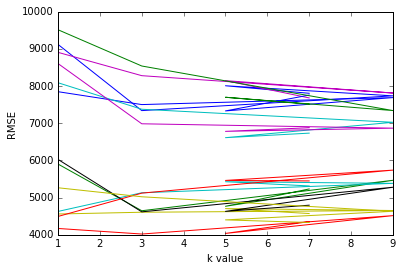

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

for k,v in k_rmse_results.items():
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x,y)
    plt.xlabel('k value')
    plt.ylabel('RMSE')

In [14]:
# Compute average RMSE across different `k` values for each feature.
feature_avg_rmse = {}
for k,v in k_rmse_results.items():
    avg_rmse = np.mean(list(v.values()))
    feature_avg_rmse[k] = avg_rmse
series_avg_rmse = pd.Series(feature_avg_rmse)
series_avg_rmse.sort_values()

horsepower           4219.377860
width                4618.910560
curb-weight          4730.075815
highway-mpg          5069.469256
length               5176.394904
city-mpg             5202.409003
wheel-base           5252.392462
compression-rate     7166.073599
bore                 7222.472445
normalized-losses    7624.407151
stroke               8000.240467
peak-rpm             8119.365233
height               8163.346266
dtype: float64

In [15]:
def knn_train_test(train_cols, target_col, df):
    np.random.seed(1)
    
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [5]
    k_rmses = {}
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[train_cols])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

two_best_features = ['horsepower', 'width']
rmse_val = knn_train_test(two_best_features, 'price', numeric_cars)
k_rmse_results["two best features"] = rmse_val

three_best_features = ['horsepower', 'width', 'curb-weight']
rmse_val = knn_train_test(three_best_features, 'price', numeric_cars)
k_rmse_results["three best features"] = rmse_val

four_best_features = ['horsepower', 'width', 'curb-weight', 'city-mpg']
rmse_val = knn_train_test(four_best_features, 'price', numeric_cars)
k_rmse_results["four best features"] = rmse_val

five_best_features = ['horsepower', 'width', 'curb-weight' , 'city-mpg' , 'highway-mpg']
rmse_val = knn_train_test(five_best_features, 'price', numeric_cars)
k_rmse_results["five best features"] = rmse_val

six_best_features = ['horsepower', 'width', 'curb-weight' , 'city-mpg' , 'highway-mpg', 'length']
rmse_val = knn_train_test(six_best_features, 'price', numeric_cars)
k_rmse_results["six best features"] = rmse_val

k_rmse_results

{'five best features': {5: 3341.6024539726504},
 'four best features': {5: 3280.3807311630976},
 'six best features': {5: 3628.2611882141268},
 'three best features': {5: 3305.9401397969677},
 'two best features': {5: 3589.3132622073304}}

In [16]:
def knn_train_test(train_cols, target_col, df):
    np.random.seed(1)
    
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [i for i in range(1, 25)]
    k_rmses = {}
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[train_cols])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

three_best_features = ['horsepower', 'width', 'curb-weight']
rmse_val = knn_train_test(three_best_features, 'price', numeric_cars)
k_rmse_results["three best features"] = rmse_val

four_best_features = ['horsepower', 'width', 'curb-weight', 'city-mpg']
rmse_val = knn_train_test(four_best_features, 'price', numeric_cars)
k_rmse_results["four best features"] = rmse_val

five_best_features = ['horsepower', 'width', 'curb-weight' , 'city-mpg' , 'highway-mpg']
rmse_val = knn_train_test(five_best_features, 'price', numeric_cars)
k_rmse_results["five best features"] = rmse_val

k_rmse_results

{'five best features': {1: 2530.0554077602005,
  2: 2897.1757974767684,
  3: 3183.4597426217424,
  4: 3168.0230415758415,
  5: 3341.6024539726504,
  6: 3537.5205429981911,
  7: 3817.2904521188252,
  8: 4004.4145296855731,
  9: 3992.3186041830318,
  10: 4138.7287878533352,
  11: 4342.0528528290979,
  12: 4416.1453810311359,
  13: 4493.8798141857205,
  14: 4463.5016015545707,
  15: 4474.480783207805,
  16: 4553.5595362768345,
  17: 4597.001081375769,
  18: 4655.283442648355,
  19: 4687.9008939828218,
  20: 4712.0229855431653,
  21: 4755.8566258237734,
  22: 4788.162720030673,
  23: 4806.9233819650544,
  24: 4879.983352195467},
 'four best features': {1: 2516.5892799502258,
  2: 2811.1727257604443,
  3: 3013.3615157930335,
  4: 3126.2694826412612,
  5: 3280.3807311630976,
  6: 3479.5099401018138,
  7: 3781.5612742414464,
  8: 3988.8669577450623,
  9: 4024.9986213622451,
  10: 4042.2472261878988,
  11: 4230.3352486840677,
  12: 4354.0086751540612,
  13: 4461.6266648777882,
  14: 4468.02984

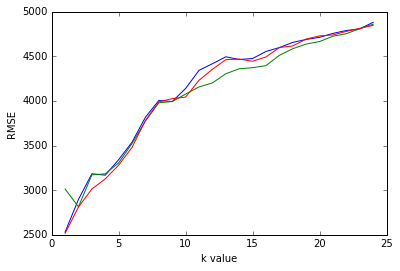

In [17]:
for k,v in k_rmse_results.items():
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x,y)
    plt.xlabel('k value')
    plt.ylabel('RMSE')